# AI-LAB SESSION 3: Tutorial

In this tutorial we will see some additional functionalities available to OpenAI Gym environments

## Lava environments

The environments used are **LavaFloor** (visible in the figure) and its variations.
![LavaFloor](images/lava.png)
The agent starts in cell $(0, 0)$ and has to reach the treasure in $(2, 3)$. In addition to the walls of the previous environments, the floor is covered with lava, there is a black pit of death. What a nice place to visit!

Moreover, the agent can't comfortably perform its actions that instead have a stochastic outcome (visible in the figure)
![DynAct](images/dynact.png)
The action dynamics is the following:
- $P(0.8)$ of moving in the desired direction
- $P(0.1)$ of moving in a direction 90° with respect to the desired direction

Finally, since the floor is covered in lava, the agent receives a negative reward for each of its steps!
- <span style="color:orange">-0.04</span> for each lava cell (L)
- <span style="color:red">-5</span> for the black pit (P). End of episode
- <span style="color:green">+1</span> for the treasure (G). End of episode

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gym
import envs
import numpy as np
from utils.funcs import run_episode, plot

env = gym.make("LavaFloor-v0")
env.render()

[['S' 'L' 'L' 'L']
 ['L' 'W' 'L' 'P']
 ['L' 'L' 'L' 'G']]


In addition to the varables of the environments you have been using in the previous sessions, there are also a few more:
- $T$: matrix of the transition function $T(s, a, s') \rightarrow [0, 1]$
- $R$: matrix of the reward function $R(s, a, s') \rightarrow \mathbb{R}$

The available actions are still *Left, Right, Up, Down*

In [2]:
print("Number of actions: ", env.action_space.n)
print("Actions: ", env.actions)

Number of actions:  4
Actions:  {0: 'L', 1: 'R', 2: 'U', 3: 'D'}


As per the action dynamics, the probability of transitioning from state $(0, 0)$ to $(0, 1)$ with action 'R' is

In [3]:
current_state = env.pos_to_state(0, 0)
next_state = env.pos_to_state(0, 1)
action_R = 1
env.T[current_state, next_state, action_R]

0.8

Indeed, the probability of actually ending up in the desired target state is 0.8.

The reward for transitioning from state $(0, 0)$ to $(0, 1)$ with action 'R' is

In [4]:
env.R[current_state, next_state, action_R]

-0.04

The agent receives the negative reward dictated by the presence of lava.

The transition probability values from state $(2, 2)$ are

In [5]:
state = env.pos_to_state(2, 2)
env.T[state]

array([[0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0.8, 0.1, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0.1, 0.8],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.8, 0. , 0. , 0.1, 0. , 0.1],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0.8, 0.1]])

The result is indexed by action/state where:
- *row*: action id
- *column*: destination state id

Reward that can be achieved from state $(2, 2)$ instead are the following

In [6]:
env.R[state, action_R]

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.04,  0.  ,  0.  ,
       -0.04, -0.04,  1.  ])

If we want to compute the best possible reward from state $(2, 2)$ we have to multiply the transition probability among the destination states (for every possible actions) and the corresponding rewards

In [7]:
pr = env.T[state] * env.R[state]
pr.max()  # Numpy max function

0.8

The best action to perform from state $(2, 2)$ takes the best possible reward for every action (keeping the max for every row with $axis=1$) and the takes the $argmax$ (returning the action id of such maximization)

In [8]:
best_action = pr.max(axis=1).argmax()
env.actions[best_action]

'R'

Now we verify that $T$ is indeed a probability (for each pair of state/action the sum is 1)

In [9]:
env.T.sum(axis=2)

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [0., 0., 0., 0.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

The null row is for the wall (W) state

To generate a random policy for the current environment we need to create a vector where in every index (state id) we take a random action $[0, ..., 4]$. Reshaping is applied in order to map to a 2-dimensional grid such as the environment

In [10]:
rnd_policy = np.random.choice(env.action_space.n, env.observation_space.n)
np.vectorize(env.actions.get)(rnd_policy.reshape(env.rows, env.cols))

array([['D', 'D', 'U', 'L'],
       ['D', 'L', 'U', 'D'],
       ['L', 'U', 'L', 'U']], dtype='<U1')

To extract multiple values, indices can be passed as tuples. For example to extract transition probability values for $T(2, 3, 2), T(2, 2, 1)$ and $T(2, 1, 6)$

In [11]:
 env.T[2, (3, 2, 1), (2, 1, 6)]

array([0. , 0.1, 0.1])

Given a policy vector it can be executed in an environment using the utility function *run_episode(environment, policy, limit)* where *limit* limits the maximum number of steps. The total *reward* is returned.

In [12]:
run_episode(env, rnd_policy, 10)

-0.39999999999999997

Since the result of the execution of a policy is stochastic (in this environment), it is useful to execute a policy multiple times and plot the rewards. In the following we execute a random and a constant policy $10$ times for a maximum number of time steps in the range $[1, 10]$. Rewards are saved in a matrix of size $10 \times 10$ where every column contains 10 iterations with the same number of maximum steps

In [13]:
const_policy = np.ones(env.observation_space.n, dtype="int8")  # Always action 1 (R)
iterations = 10
step_limit = range(1, 11)

# Reward matrices
rnd_rewards = np.zeros((iterations, len(step_limit)))
const_rewards = np.zeros((iterations, len(step_limit)))

for i in range(10):
    for j in step_limit:
        rnd_rewards[i, j - 1] = run_episode(env, rnd_policy, j)
        const_rewards[i, j - 1] = run_episode(env, const_policy, j)

It is useful to plot the mean result for each step limit with the utility function *plot* that takes the following arguments:
- *series*: a list of dictionaries such as $(\{"x": [1, 2, 3], "y": [10, 20, 30] "label": "first"\}, \{"x": [1, 2, 3], "y": [100, 200, 300] "label": "second"\})$
- *title*: the title of the chart
- *xlabel*: label for x-axis
- *ylabel*: label fo y-axis

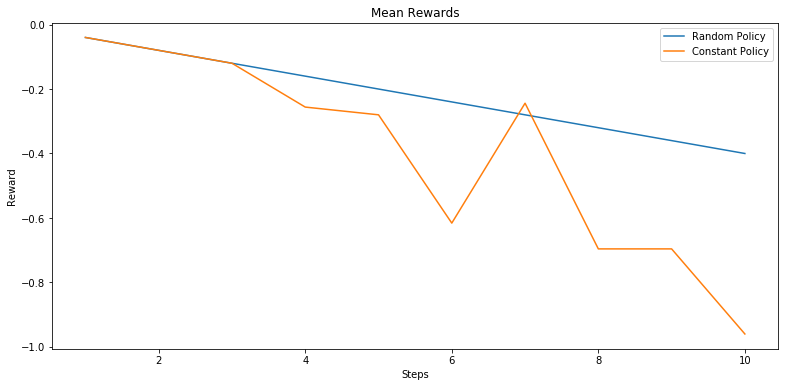

In [14]:
rnd_series = {"x": step_limit, "y": rnd_rewards.mean(axis=0), "label": "Random Policy"}
const_series = {"x": step_limit, "y": const_rewards.mean(axis=0), "label": "Constant Policy"}
plot((rnd_series, const_series), "Mean Rewards", "Steps", "Reward")